DWI bvalues: ['0', '50', '350', '600', '900', '1150', '100', '400', '650', '950', '150', '450', '700', '1000', '1300', '200', '500', '800', '1050', '1350', '300', '850', '1100', '1400']


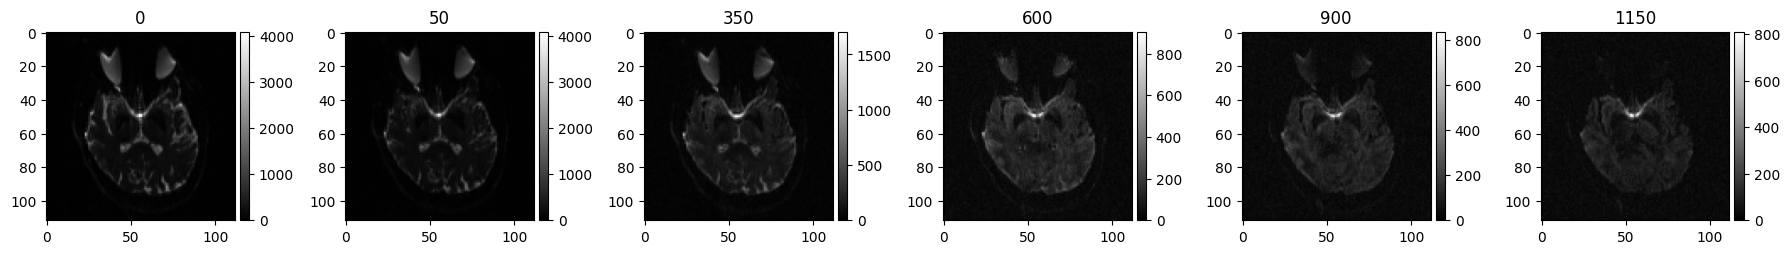

In [3]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import nibabel as nib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import split_name_with_nii, get_slice, get_nifti_data, get_nifti_header_info, summarize_intensities

# Diffusion is 4D data and along the 4th dimension, intensity vary!
PATH_DWI = 'data/bids/dwi/sub-X_ses-Y_run-01_dwi.nii.gz'
PATH_DWI_MASK = 'data/bids/dwi/sub-X_ses-Y_run-01_dwi_mask.nii.gz'
# PATH_DWI = 'data/bids/dwi/sub-X_ses-Y_run-02_dwi.nii.gz'
# PATH_DWI_MASK = 'data/bids/dwi/sub-X_ses-Y_run-02_dwi_mask.nii.gz'

img_dwi = nib.load(PATH_DWI)
data_dwi = get_nifti_data(img_dwi)

img_mask = nib.load(PATH_DWI_MASK)
data_mask = get_nifti_data(img_mask)

with open(PATH_DWI.replace('.nii.gz', '.bval')) as f:
    bvals = f.readlines()[0].split()
print('DWI bvalues:', bvals)

fig, axs = plt.subplots(1, 6, figsize=(18, 6))
ax_slice_dwi_b100 = get_slice(data_dwi[..., 0], 'axial')
for i in range(6):
    ax_slice = get_slice(data_dwi[..., i], 'axial')
    im = axs[i].imshow(ax_slice, cmap='gray')
    axs[i].set_title(str(bvals[i]))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
fig.tight_layout()
plt.show()

bvals: 0 snr: 3.6690722898302726
bvals: 50 snr: 3.179125831104024
bvals: 350 snr: 2.248740369049031
bvals: 600 snr: 1.7078512358952644
bvals: 900 snr: 1.7111306529893324
bvals: 1150 snr: 1.5822054808493424


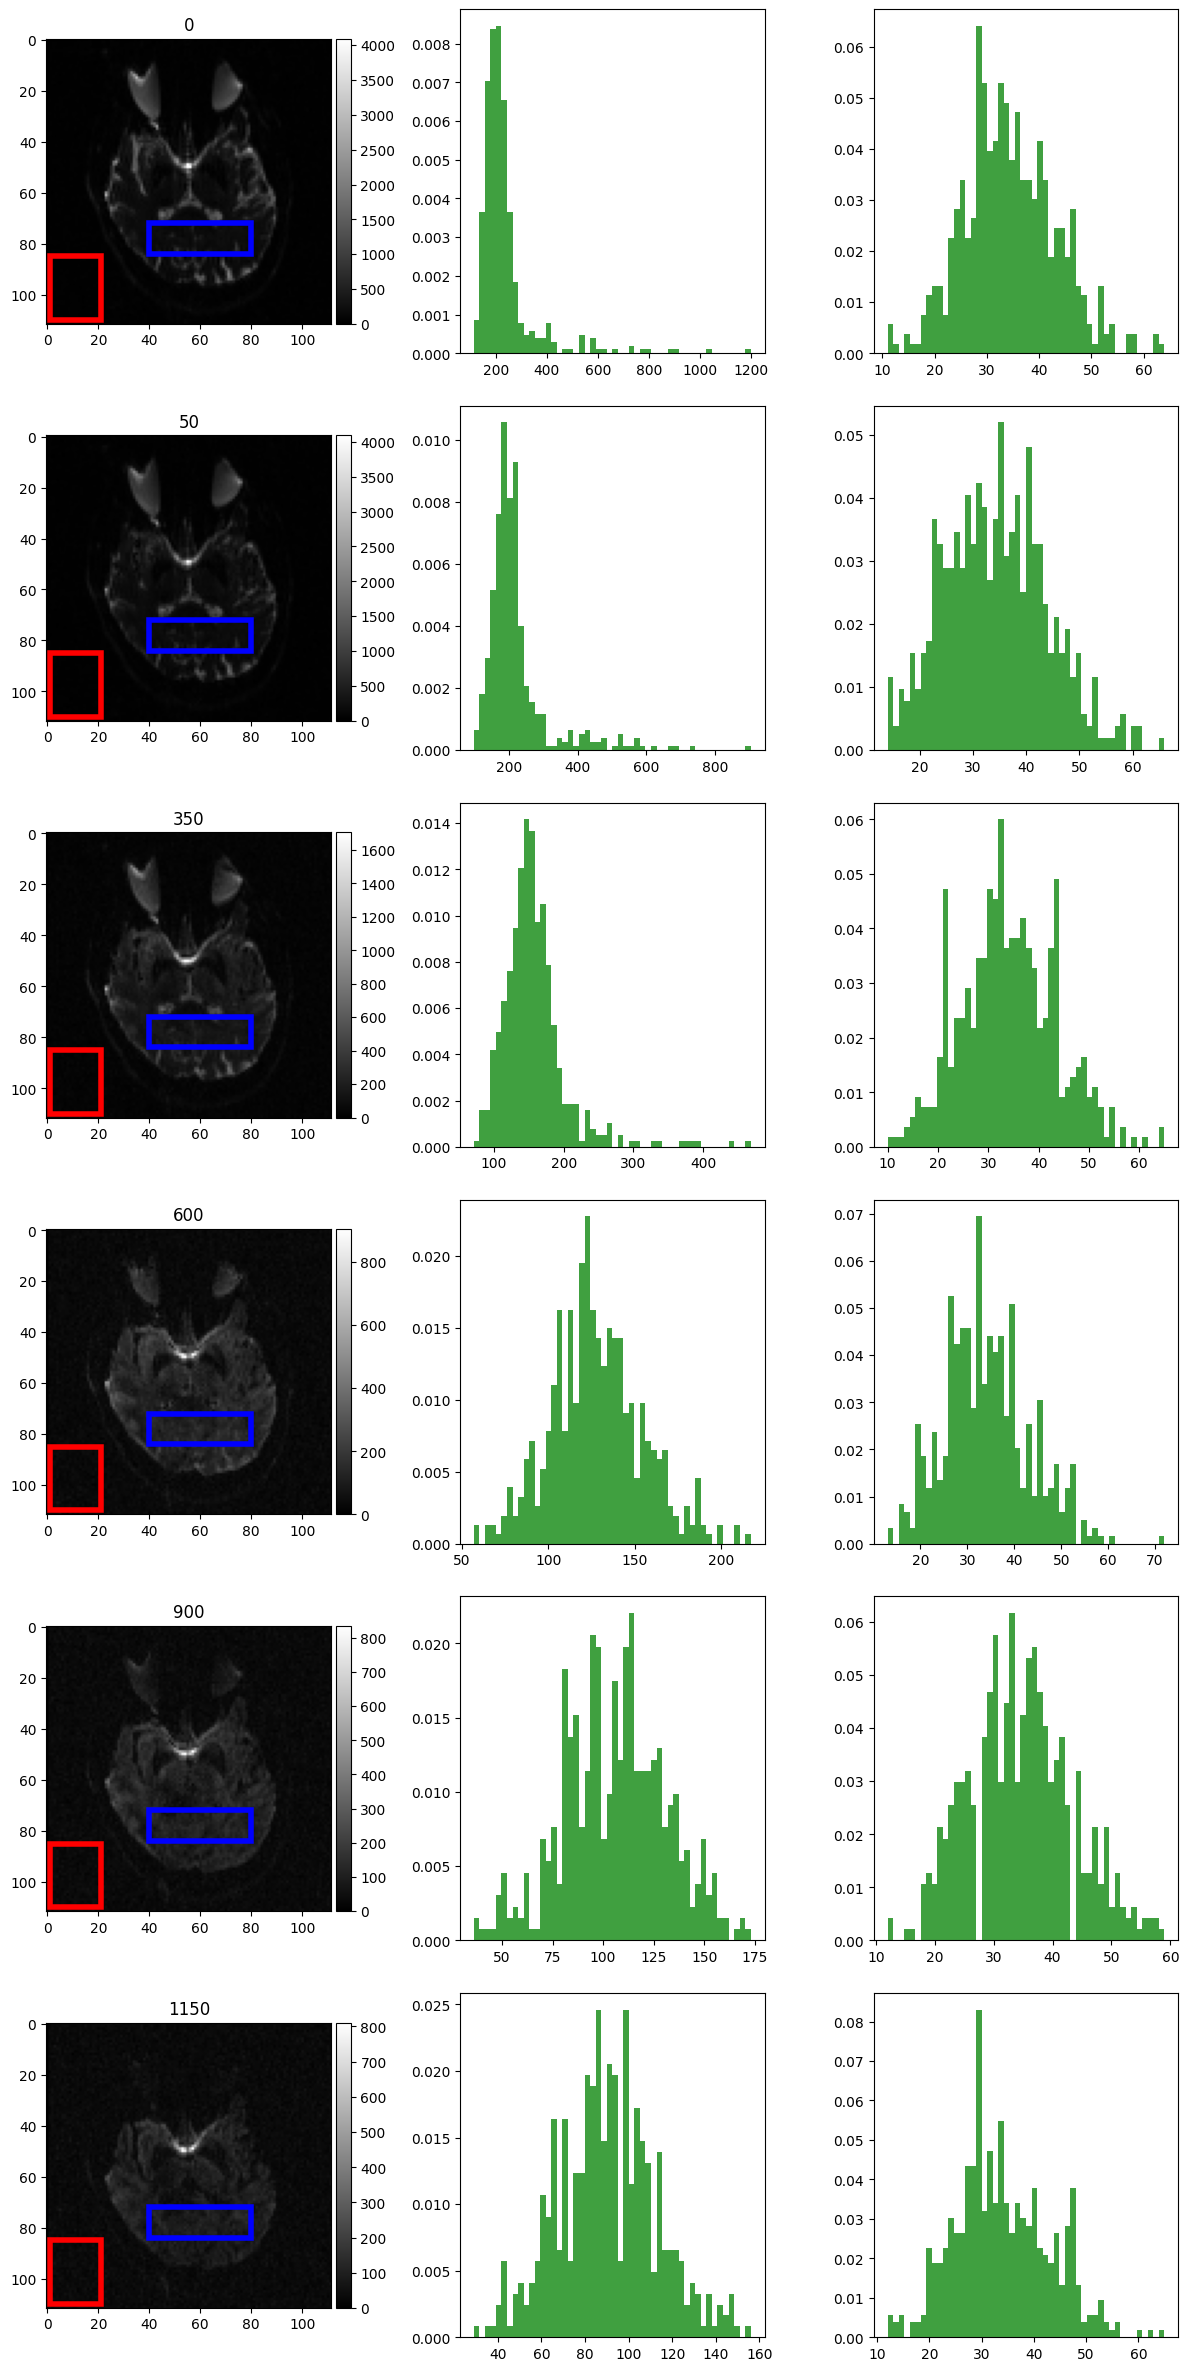

In [4]:
from matplotlib.patches import Rectangle

def compute_snr_v1(data, corner_s, size_s, corner_n, size_n):
    patch_s = data[corner_s[1]:corner_s[1]+size_s[1], corner_s[0]:corner_s[0]+size_s[0]]
    patch_n = data[corner_n[1]:corner_n[1]+size_n[1], corner_n[0]:corner_n[0]+size_n[0]]
    
    std_s = np.std(patch_s)
    std_n = np.std(patch_n)

    return np.sqrt(std_s/std_n), patch_s, patch_n

# Manually found for this image
CORNER_S = (40, 72)
SIZE_S = (40, 12)
CORNER_N = (1, 85)
SIZE_N = (20, 25)

fig, axs = plt.subplots(6, 3, figsize=(12, 24))
for i in range(6):
    ax_slice = get_slice(data_dwi[..., i], 'axial')
    im = axs[i, 0].imshow(ax_slice, cmap='gray')
    axs[i, 0].set_title(str(bvals[i]))
    divider = make_axes_locatable(axs[i, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    snr, patch_s, patch_n = compute_snr_v1(ax_slice, CORNER_S, SIZE_S,
                                         CORNER_N, SIZE_N)
    n, bins, patches = axs[i, 1].hist(patch_s.ravel(), 50, density=True, facecolor='g', alpha=0.75)
    axs[i, 0].add_patch(Rectangle(CORNER_S, SIZE_S[0], SIZE_S[1],
                              edgecolor='blue',
                              facecolor='none',
                              lw=4))
    n, bins, patches = axs[i, 2].hist(patch_n.ravel(), 50, density=True, facecolor='g', alpha=0.75)
    axs[i, 0].add_patch(Rectangle(CORNER_N, SIZE_N[0], SIZE_N[1],
                                  edgecolor='red',
                                  facecolor='none',
                                  lw=4))
#     iio.imwrite('n_{}.png'.format(bvals[i]), patch_n)
#     iio.imwrite('s_{}.png'.format(bvals[i]), patch_s)
    print('bvals:', bvals[i], 'snr:', snr)
fig.tight_layout()
plt.show()

# Calcul du rapport signal-sur-bruit en imagerie de diffusion

Ce chapitre explore l'analyse des données de diffusion IRM (Diffusion Weighted Imaging), où le rapport signal-sur-bruit varie selon les paramètres d'acquisition.

---

## Concepts clés

- **Données 4D** : images 3D acquises à différentes valeurs de diffusion
- **Paramètres b-value** : intensité du gradient de diffusion
- **Variation du SNR** : relation entre diffusion et qualité du signal
- **Régions d'intérêt (ROI)** : analyse spatiale du SNR

In [5]:
# Importation des bibliothèques
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import split_name_with_nii, get_slice, get_nifti_data, get_nifti_header_info, summarize_intensities

---

## Chargement des données de diffusion

Les fichiers DWI (Diffusion Weighted Imaging) contiennent une série d'images 3D (tenseur 4D). Chaque volume correspond à une b-value (intensité de diffusion) différente.

In [6]:
# Chemins des données
PATH_DWI = './test_dataset/dwi/sub-X_ses-Y_run-01_dwi.nii.gz'
PATH_DWI_MASK = './test_dataset/dwi/sub-X_ses-Y_run-01_dwi_mask.nii.gz'

# Charger les fichiers NIfTI
img_dwi = nib.load(PATH_DWI)
data_dwi = get_nifti_data(img_dwi)

img_mask = nib.load(PATH_DWI_MASK)
data_mask = get_nifti_data(img_mask)

# Lire les b-values depuis le fichier .bval
with open(PATH_DWI.replace('.nii.gz', '.bval')) as f:
    bvals = f.readlines()[0].split()

print(f"Dimensions des données DWI : {data_dwi.shape}")
print(f"Nombre de volumes : {len(bvals)}")
print(f"B-values : {bvals}")

FileNotFoundError: No such file or no access: 'test_dataset/dwi/sub-X_ses-Y_run-01_dwi.nii.gz'

---

## Visualisation des volumes à différentes b-values

Afficher des coupes axiales pour les 6 premiers volumes, montrant comment l'intensité du signal varie avec la b-value.

In [ ]:
# Afficher les 6 premiers volumes avec leurs b-values respectives
fig, axs = plt.subplots(1, 6, figsize=(18, 6))

for i in range(6):
    # Extraire une coupe axiale du volume i
    ax_slice = get_slice(data_dwi[..., i], 'axial')
    
    # Afficher et colorbar
    im = axs[i].imshow(ax_slice, cmap='gray')
    axs[i].set_title(f"b-value = {bvals[i]}")
    axs[i].axis('off')
    
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

fig.tight_layout()
plt.show()

print(f"Observer : à mesure que la b-value augmente, le signal diminue")

---

## Calcul du SNR pour chaque b-value

Extraire des régions d'intérêt (ROI) de signal et de bruit, puis calculer le SNR pour chaque volume.

**Approche** :
- **Signal** : région dans le tissu cérébral
- **Bruit** : région en dehors du cerveau (avec peu ou pas de signal)

In [ ]:
from matplotlib.patches import Rectangle

def compute_snr_dwi(data, corner_signal, size_signal, corner_noise, size_noise):
    """Calculer le SNR en comparant l'écart-type du signal et du bruit."""
    # Extraire les ROI de signal et bruit
    roi_signal = data[corner_signal[1]:corner_signal[1]+size_signal[1], 
                      corner_signal[0]:corner_signal[0]+size_signal[0]]
    roi_noise = data[corner_noise[1]:corner_noise[1]+size_noise[1],
                     corner_noise[0]:corner_noise[0]+size_noise[0]]
    
    # Calculer l'écart-type de chaque région
    std_signal = np.std(roi_signal)
    std_noise = np.std(roi_noise)
    
    # SNR = sqrt(std_signal / std_noise)
    snr = np.sqrt(std_signal / std_noise) if std_noise > 0 else 0
    
    return snr, roi_signal, roi_noise

# Définir les ROI (trouvées manuellement)
CORNER_SIGNAL = (40, 72)    # Coin supérieur gauche du signal
SIZE_SIGNAL = (40, 12)      # Dimensions
CORNER_NOISE = (1, 85)      # Coin du bruit
SIZE_NOISE = (20, 25)       # Dimensions

# Calculer le SNR pour chaque volume
print("Calcul du SNR pour chaque b-value :\n")
print("B-value | SNR")
print("-" * 25)

snr_values = []

for i in range(6):
    # Extraire une coupe axiale
    ax_slice = get_slice(data_dwi[..., i], 'axial')
    
    # Calculer SNR
    snr, roi_sig, roi_noise = compute_snr_dwi(ax_slice, CORNER_SIGNAL, SIZE_SIGNAL,
                                              CORNER_NOISE, SIZE_NOISE)
    snr_values.append(snr)
    
    print(f"{bvals[i]:>7} | {snr:.3f}")

# Tracer la courbe SNR en fonction de la b-value
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Extraire la coupe
    ax_slice = get_slice(data_dwi[..., i], 'axial')
    
    # Afficher l'image
    im = ax.imshow(ax_slice, cmap='gray')
    
    # Calculer et afficher le SNR
    snr, roi_sig, roi_noise = compute_snr_dwi(ax_slice, CORNER_SIGNAL, SIZE_SIGNAL,
                                              CORNER_NOISE, SIZE_NOISE)
    
    # Marquer les ROI
    ax.add_patch(Rectangle(CORNER_SIGNAL, SIZE_SIGNAL[0], SIZE_SIGNAL[1],
                          edgecolor='blue', facecolor='none', lw=2))
    ax.add_patch(Rectangle(CORNER_NOISE, SIZE_NOISE[0], SIZE_NOISE[1],
                          edgecolor='red', facecolor='none', lw=2))
    
    ax.set_title(f"b = {bvals[i]}, SNR = {snr:.3f}")
    ax.axis('off')

fig.tight_layout()
plt.show()

---

## Visualisation de l'histogramme des intensités

Pour chaque b-value, afficher l'histogramme du signal dans les ROI.

In [ ]:
# Créer une figure avec les histogrammes
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i in range(6):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Extraire la coupe
    ax_slice = get_slice(data_dwi[..., i], 'axial')
    
    # Calculer SNR et extraire ROI
    snr, roi_sig, roi_noise = compute_snr_dwi(ax_slice, CORNER_SIGNAL, SIZE_SIGNAL,
                                              CORNER_NOISE, SIZE_NOISE)
    
    # Tracer histogrammes
    ax.hist(roi_sig.ravel(), bins=30, alpha=0.6, color='blue', label='Signal', density=True)
    ax.hist(roi_noise.ravel(), bins=30, alpha=0.6, color='red', label='Bruit', density=True)
    
    ax.set_title(f"b = {bvals[i]}, SNR = {snr:.3f}")
    ax.set_xlabel("Intensité")
    ax.set_ylabel("Fréquence normalisée")
    ax.legend()

fig.tight_layout()
plt.show()

print(f"Observation : à mesure que b-value augmente, le signal décroît plus vite que le bruit")

---

## Résumé

- **Données 4D** : images de diffusion avec plusieurs b-values
- **B-values** : contrôlent l'intensité de la diffusion
- **SNR par volume** : varie en fonction de la b-value
- **ROI** : localisation spatiale pour calculs précis
- **Diffusion** : augmente, le signal diminue exponentiellement

Fin de la série de chapitres sur le traitement d'images.